# Análise de sistemas não lineares e invariantes no tempo

Neste notebook avaliamos a medição de sistemas não lineares e invariantes no tempo. Estamos interessados em descrever sistemas invariantes no tempo, cuja resposta ao sinal $x(t)$ seja

\begin{equation}
y(t) = \psi(x(t)*h_L(t)) = \psi(y_L(t)),
\end{equation}
em que $h_L(t)$ é a parte linear da resposta do sistema e $\psi(x)$ é uma função não-linear, que impõe não linearidades ao sistema.

Vamos avaliar como diferentes sinais do tipo:

- seno;
- sweeps linear e logarítmico;
- MLS;

conseguem lidar com o problema. Particularmente, veremos que o ***sweeps logarítmico*** possui uma interessante propriedade.

In [1]:
# importar as bibliotecas necessárias
import numpy as np # arrays
import matplotlib.pyplot as plt # plots
plt.rcParams.update({'font.size': 14})
from scipy import signal
import IPython.display as ipd # to play signals
import sounddevice as sd
import soundfile as sf

# O sistema

O sistema não linear é composto por uma parte linear e uma parte não linear. As não linearidades são geradas por uma função do tipo sigmoide, cuja entrada é a convolução entre $x(t)$ e $h(t)$, dada por

\begin{equation}
y(t) = \frac{2\ \mathrm{max}[x(t)*h(t)]}{\Big(0.5+\mathrm{e}^{-0.7x(t)*h(t)} \Big)},
\end{equation}

In [3]:
def black_box(xt, Fs = 44100, snr = 1000, distortion = True):
    """ SLIT black box
    
    Author: Eric Brandão - 11/2020
    This function emulates a SLIT measurement. System parameters
    are used to generate a reference h(t) and FRF. We, then, compute
    noiseless versions of x(t) and y(t) using the FFT. We add noise
    to the signals. The SNR is calculated based on x(t). Finally,
    we apply a low pass filter to emulate an anti-aliasing filter.
    
    Parameters:
    -------------
    xt : numpy 1darray
        Input signal
    Fs : int
        Sampling frequency
    snr : float
        Signal to noise ratio relative to x(t)
    noise_at : str
        Choose to which signal you apply noise. If 'out', 
        noise is applied only to y(t), if 'in', noise is applied
        only to x(t). else, noise is applied to both signals
    
    Returns:
    ------------
    th : numpy 1darray
        time vector of reference impulse response
    h : numpy 1darray
        reference impulse response
    fh : numpy 1darray
        frequency vector of reference FRF
    H : numpy 1darray
        reference FRF (Frequency Response Function)
    ty : numpy 1darray
        time vector of the output signal
    yt : numpy 1darray
        output signal  with added noise
    tx : numpy 1darray
        time vector of the input signal
    xt : numpy 1darray
        input signal with added noise
    """
    # System parameters
    A = [2.3, 1.5]
    f_res = [110, 415]
    w_res = 2*np.pi*np.array(f_res)
    zeta = [0.02, 0.01]
    wd = np.sqrt(1-np.array(zeta)**2)*np.array(w_res)
    # Reference impulse response
    th = np.arange(0, 1, 1/Fs)
    h=(A[0]/wd[0])*np.exp(-zeta[0]*w_res[0]*th)*np.sin(wd[0]*th) +\
        (A[1]/wd[1])*np.exp(-zeta[1]*w_res[1]*th)*np.sin(wd[1]*th)
    # reference frequency response
    fh = np.linspace(0, (len(h)-1)*Fs/len(h), len(h))
    H = (A[0]/(w_res[0]**2 - (2*np.pi*fh)**2 + 1j*2*zeta[0]*w_res[0]*(2*np.pi*fh)) +\
        A[1]/(w_res[1]**2 - (2*np.pi*fh)**2 + 1j*2*zeta[1]*w_res[1]*(2*np.pi*fh)))*Fs
    # Compute SLIT noiseless output
    N = len(xt) + len(h) - 1
    Xjw = np.fft.fft(xt, N)
    Hjw = np.fft.fft(h, N)
    Yjw = Xjw * Hjw
    yt = np.real(np.fft.ifft(Yjw))
    ty = np.linspace(0, (N-1)/Fs, N)
    # add noise to signals
    y_var = (np.std(yt))**2 # input RMS**2, assuming zero mean
    noise_var_dB = 10*np.log10(y_var) - snr
    noise_var = 10**(noise_var_dB/10)
    yt = yt + np.random.normal(loc=0, scale = np.sqrt(noise_var), size = len(yt))
    # Complete xt with zeros
    xt = np.concatenate([xt, np.zeros(N-len(xt))])
    tx = np.linspace(0, (len(xt)-1)/Fs, len(xt))
    # Impose non-linearity
    if distortion:
        yt = (1/(1+np.exp(-0.7*yt))-0.5)*2*np.amax(yt)
    return th, h, fh, H, ty, yt, tx, xt
    

# Relação de não linearidade

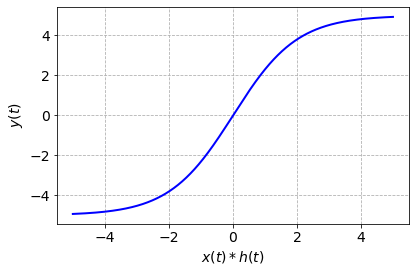

In [4]:
amps = np.arange(-5, 5, 0.01)
dist = (1/(1+np.exp(-1*amps))-0.5)*2*np.amax(amps)

plt.figure()
plt.plot(amps, dist, '-b', linewidth = 2)
plt.grid(linestyle = '--', which='both')
plt.xlabel(r'$x(t)*h(t)$')
plt.ylabel(r'$y(t)$')
plt.tight_layout()
plt.show()

# Resposta do sistema a um seno

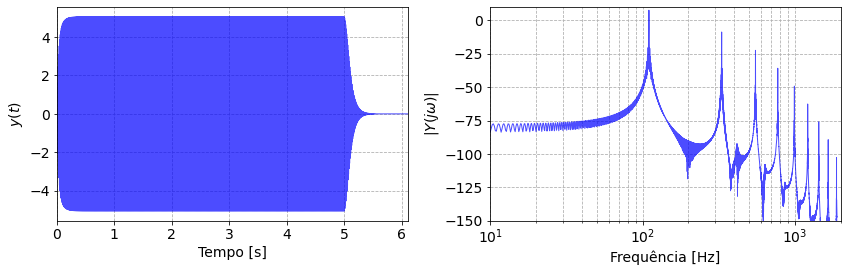

In [17]:
fs = 44100
time = np.arange(0, 5, 1/fs)

xt = np.sin(2*np.pi*110*time)
# silencio no final
t_sil = 0.1
xt = np.concatenate([xt, np.zeros(int(fs*t_sil))])

# Passar o sinal pelo sistema
th, h, fh, H, ty, yt, tx, xt = black_box(xt, Fs = fs, distortion = True)
Yw = np.fft.fft(yt)
freq = np.linspace(0, (len(Yw)-1)*fs/len(Yw), len(Yw))


# Plotar yt e seu espectro

plt.figure(figsize = (12, 4))
plt.subplot(1,2,1)
plt.plot(ty, yt, linewidth = 1, color = 'b', alpha = 0.7)
plt.grid(linestyle = '--', which='both')
plt.ylabel(r'$y(t)$')
plt.xlim((0, ty[-1]))
plt.xlabel('Tempo [s]')

plt.subplot(1,2,2)
plt.semilogx(freq, 20*np.log10(np.abs(Yw)/len(Yw)), linewidth = 1, color = 'b', alpha = 0.7)
plt.grid(linestyle = '--', which='both')
plt.ylabel(r'$|Y(j \omega)|$')
plt.xlim((10, 2000))
plt.ylim((-150, 10))
plt.xlabel('Frequência [Hz]')
plt.tight_layout()

ipd.Audio(yt, rate=fs) # load a NumPy array

# Sweep Logarítmico

Este sinal, $x(t)$, é o sinal que você entregaria ao seu SLIT sem qualquer contaminação.

In [18]:
fs = 44100
time = np.arange(0, 5, 1/fs)
# sinal
xt = signal.chirp(time, 100, time[-1], 10000, method='logarithmic') #'logarithmic'
# silencio no final
t_sil = 0.1
xt = np.concatenate([xt, np.zeros(int(fs*t_sil))])
ipd.Audio(xt, rate=fs) # load a NumPy array

# Passar $x(t)$ pelo SLIT

Neste passo, vamos passar o sinal ao SLIT. O SLIT emula um sistema com duas ressonâncias e uma anti-ressonância e as não linearidades. A função também emula a adição de ruído e o filtro anti-aliasing presente no seu conversor AD.

In [22]:
th, h, fh, H, ty, yt, tx, xt = black_box(xt, Fs = fs, distortion = True)

# Inspecione $x(t)$ e $y(t)$ - talvez haja algum insight

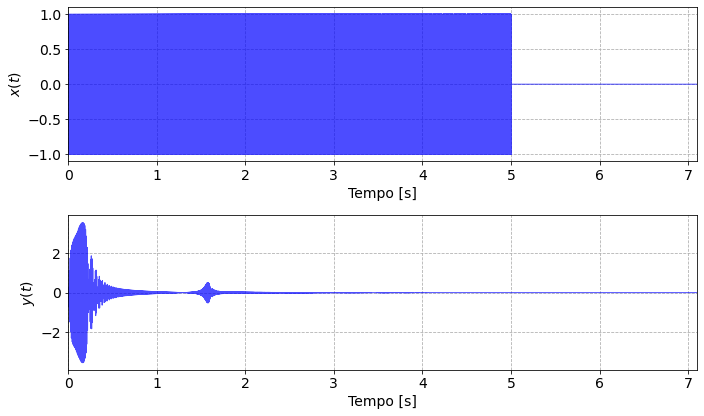

In [23]:
plt.figure(figsize = (10, 6))
plt.subplot(2,1,1)
plt.plot(tx, xt, linewidth = 1, color = 'b', alpha = 0.7)
plt.grid(linestyle = '--', which='both')
plt.ylabel(r'$x(t)$')
plt.xlim((0, ty[-1]))
plt.xlabel('Tempo [s]')

plt.subplot(2,1,2)
plt.plot(ty, yt, linewidth = 1, color = 'b', alpha = 0.7)
plt.grid(linestyle = '--', which='both')
plt.ylabel(r'$y(t)$')
plt.xlim((0, ty[-1]))
plt.xlabel('Tempo [s]')
plt.tight_layout()

# Compute FRF and $h(t)$

O sweep logarítmico tem uma interessante propriedade:

- As não-linearidades se agrupam, por odem, no fim da resposta ao impulso; 
- A parte linear da FRF fica concentrada no início;

[1] - Angelo Farina, Simultaneous measurement of impulse response and distortion with a swept-sine technique, Presented at the 108th ***AES*** Convention 2000 February 19-22 Paris, France.



Isto está relacionado a dois fatores típicos do sweep logarítmico:

1. As componentes de frequência não são excitadas ao mesmo tempo
2. A evolução exponencial da frequência do sweep cria o agrupamento

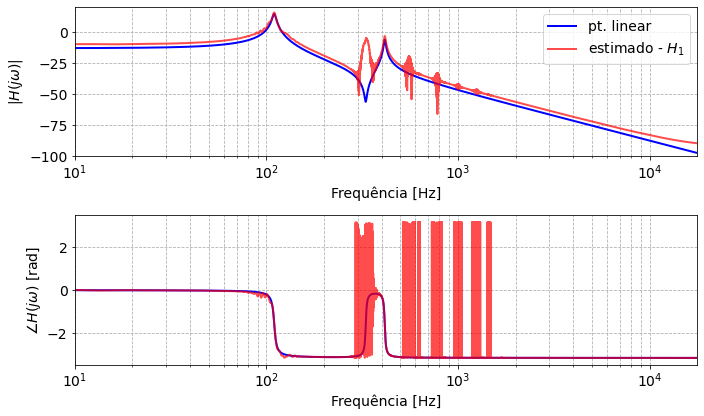

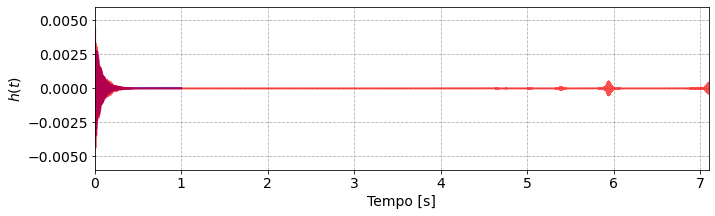

In [24]:
# Computar a resposta ao impulso
nfft = len(xt)+len(yt)-1
Xw = np.fft.fft(xt)
Yw = np.fft.fft(yt)

Hw = Yw/Xw
freq = np.linspace(0, (len(Hw)-1)*fs/len(Hw), len(Hw))

ht = np.real(np.fft.ifft(Hw))
tht = np.linspace(0, (len(ht)-1)/fs, len(ht))

# Plot
plt.figure(figsize = (10, 6))
plt.subplot(2,1,1)
plt.semilogx(fh, 20*np.log10(np.abs(H)), linewidth = 2, color = 'b', label = 'pt. linear')
plt.semilogx(freq, 20*np.log10(np.abs(Hw)), linewidth = 2, color = 'r', alpha=0.7, label = r'estimado - $H_1$')
plt.legend(loc = 'upper right')
plt.grid(linestyle = '--', which='both')
plt.ylabel(r'$|H(j \omega)|$')
plt.xlim((10, 0.8*fs/2))
plt.ylim((-100, 20))
plt.xlabel('Frequência [Hz]')

plt.subplot(2,1,2)
plt.semilogx(fh, np.angle(H), linewidth = 2, color = 'b')
plt.semilogx(freq, np.angle(Hw), linewidth = 2, color = 'r', alpha=0.7)
plt.grid(linestyle = '--', which='both')
plt.ylabel(r'$\angle H(j \omega)$ [rad]')
plt.xlim((10, 0.8*fs/2))
#plt.ylim((-4, 4))
plt.xlabel('Frequência [Hz]')
plt.tight_layout()


plt.figure(figsize = (11, 3))
plt.plot(th, h, linewidth = 2, color = 'b', label = 'ref.')
plt.plot(tht, ht, linewidth = 2, color = 'r', alpha = 0.7)
plt.grid(linestyle = '--', which='both')
plt.ylabel(r'$h(t)$')
plt.xlabel('Tempo [s]')
#plt.xlim((0, 1));
plt.xlim((0, tht[-1]));
plt.ylim((-6e-3, 6e-3));

# Janelar a parte inicial.

Agora podemos tentar eliminar as distorções por um janelamento temporal. Vamos usar uma janela híbrida feita de:

- 1 parte retangular;
- 1 fade out do tipo hanning;
- o restante de zeros;

In [25]:
def hybrid_window(len_xt, t_init_fadeout = 2, fadeout_dur = 0.5, fs=44100):
    """ Definies a hybrid window
    """
    # get the number of samples up to t_init_fadeout
    n_init_fadeout = int(fs*t_init_fadeout)
    # create first part of window
    rect_win = np.ones(n_init_fadeout)
    # Get the number of samples in the fadeout part
    n_fadeout = int(fadeout_dur*fs)
    # Create a hanning window
    hann_win = signal.hann(2*n_fadeout)
    # get the later half of the window
    fadeout_win = hann_win[n_fadeout:]
    # get the number of remaining zeros
    n_zeros = len_xt - len(rect_win) - len(fadeout_win)
    # create zeros 
    zero_win = np.zeros(n_zeros)
    # Concatenate window
    win = np.concatenate((rect_win, fadeout_win, zero_win))
    return win
    

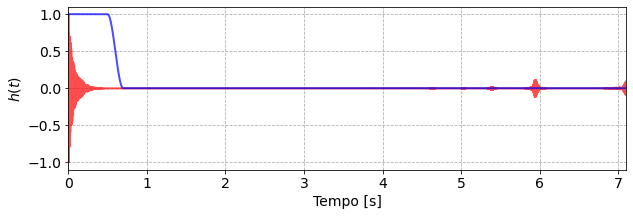

In [26]:
win = hybrid_window(len(ht), t_init_fadeout = 0.5, fadeout_dur = 0.2, fs=44100)

# Plot
plt.figure(figsize = (10, 3))
plt.plot(tht, ht/np.amax(ht), linewidth = 2, color = 'r', alpha = 0.7)
plt.plot(tht, win, linewidth = 2, color = 'b', alpha = 0.7)
plt.grid(linestyle = '--', which='both')
plt.ylabel(r'$h(t)$')
plt.xlabel('Tempo [s]')
plt.xlim((0, tht[-1]));

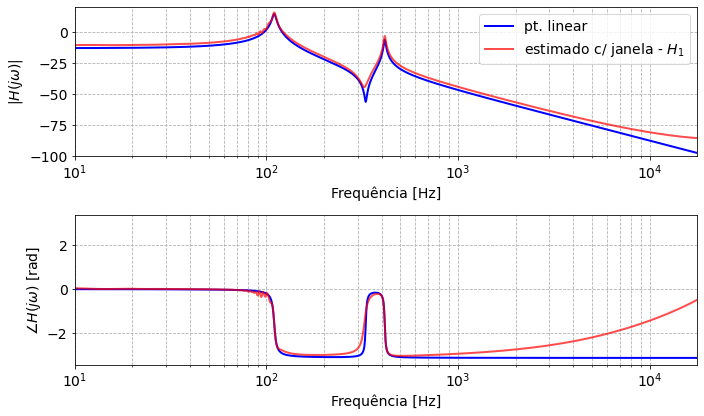

In [27]:
ht_win = ht * win
Hw_win = np.fft.fft(ht_win)

# Plot
plt.figure(figsize = (10, 6))
plt.subplot(2,1,1)
plt.semilogx(fh, 20*np.log10(np.abs(H)), linewidth = 2, color = 'b', label = 'pt. linear')
plt.semilogx(freq, 20*np.log10(np.abs(Hw_win)), linewidth = 2, color = 'r', alpha=0.7, label = r'estimado c/ janela - $H_1$')
plt.legend(loc = 'upper right')
plt.grid(linestyle = '--', which='both')
plt.ylabel(r'$|H(j \omega)|$')
plt.xlim((10, 0.8*fs/2))
plt.ylim((-100, 20))
plt.xlabel('Frequência [Hz]')

plt.subplot(2,1,2)
plt.semilogx(fh, np.angle(H), linewidth = 2, color = 'b')
plt.semilogx(freq, np.angle(Hw_win), linewidth = 2, color = 'r', alpha=0.7)
plt.grid(linestyle = '--', which='both')
plt.ylabel(r'$\angle H(j \omega)$ [rad]')
plt.xlim((10, 0.8*fs/2))
#plt.ylim((-4, 4))
plt.xlabel('Frequência [Hz]')
plt.tight_layout()


# Outros sinais

Agora podemos avaliar o que acontece com o sweep linear e com o sinal MLS.

## 1. sweep linear

Embora as componentes de frequência não sejam excitadas ao mesmo tempo, a evolução linear da frequência do sweep não permite o agrupamento das distorções harmônicas.

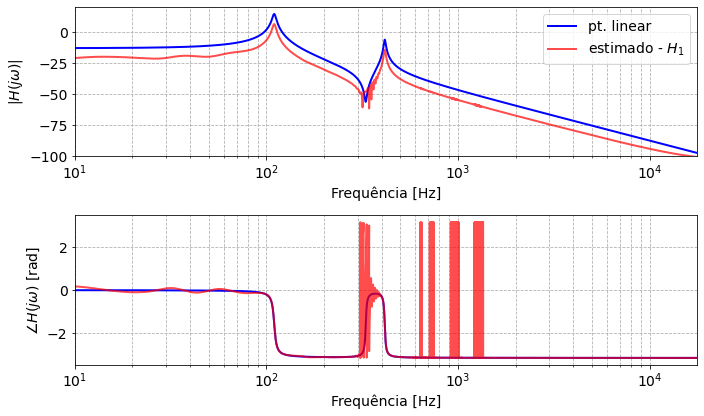

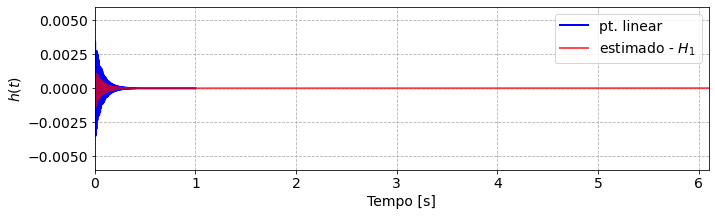

In [28]:
fs = 44100
time = np.arange(0, 5, 1/fs)
# sinal
xt = signal.chirp(time, 100, time[-1], 10000, method='linear') #'logarithmic'
# silencio no final
t_sil = 0.1
xt = np.concatenate([xt, np.zeros(int(fs*t_sil))])

th, h, fh, H, ty, yt, tx, xt = black_box(xt, Fs = fs, distortion = True)

# Computar a resposta ao impulso
nfft = len(xt)+len(yt)-1
Xw = np.fft.fft(xt)
Yw = np.fft.fft(yt)

Hw = Yw/Xw
freq = np.linspace(0, (len(Hw)-1)*fs/len(Hw), len(Hw))

ht = np.real(np.fft.ifft(Hw))
tht = np.linspace(0, (len(ht)-1)/fs, len(ht))

# Plot
plt.figure(figsize = (10, 6))
plt.subplot(2,1,1)
plt.semilogx(fh, 20*np.log10(np.abs(H)), linewidth = 2, color = 'b', label = 'pt. linear')
plt.semilogx(freq, 20*np.log10(np.abs(Hw)), linewidth = 2, color = 'r', alpha=0.7, label = r'estimado - $H_1$')
plt.legend(loc = 'upper right')
plt.grid(linestyle = '--', which='both')
plt.ylabel(r'$|H(j \omega)|$')
plt.xlim((10, 0.8*fs/2))
plt.ylim((-100, 20))
plt.xlabel('Frequência [Hz]')

plt.subplot(2,1,2)
plt.semilogx(fh, np.angle(H), linewidth = 2, color = 'b')
plt.semilogx(freq, np.angle(Hw), linewidth = 2, color = 'r', alpha=0.7)
plt.grid(linestyle = '--', which='both')
plt.ylabel(r'$\angle H(j \omega)$ [rad]')
plt.xlim((10, 0.8*fs/2))
#plt.ylim((-4, 4))
plt.xlabel('Frequência [Hz]')
plt.tight_layout()


plt.figure(figsize = (11, 3))
plt.plot(th, h, linewidth = 2, color = 'b', label = 'pt. linear')
plt.plot(tht, ht, linewidth = 2, color = 'r', alpha = 0.7, label = r'estimado - $H_1$')
plt.legend(loc = 'upper right')
plt.grid(linestyle = '--', which='both')
plt.ylabel(r'$h(t)$')
plt.xlabel('Tempo [s]')
plt.xlim((0, tht[-1]))
plt.ylim((-6e-3, 6e-3));

## 2. MLS

As componentes de frequência são excitadas ao mesmo tempo, o que implica que é impossível separar as distorções harmônicas.

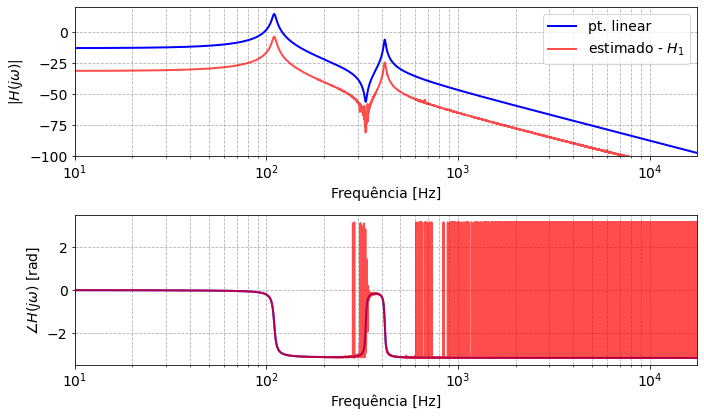

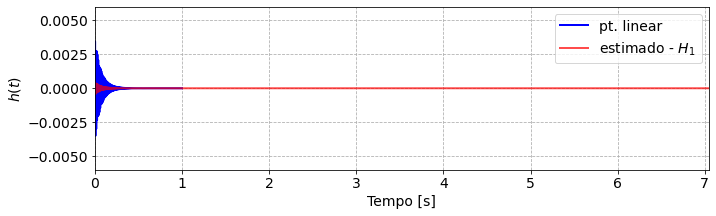

In [29]:
fs = 44100
order = 18
# sinal
xt = 2*(signal.max_len_seq(order)[0]-0.5)
# silencio no final
t_sil = 0.1
xt = np.concatenate([xt, np.zeros(int(fs*t_sil))])

th, h, fh, H, ty, yt, tx, xt = black_box(xt, Fs = fs, distortion = True)

# Computar a resposta ao impulso
nfft = len(xt)+len(yt)-1
Xw = np.fft.fft(xt)
Yw = np.fft.fft(yt)

Hw = Yw/Xw
freq = np.linspace(0, (len(Hw)-1)*fs/len(Hw), len(Hw))

ht = np.real(np.fft.ifft(Hw))
tht = np.linspace(0, (len(ht)-1)/fs, len(ht))

# Plot
plt.figure(figsize = (10, 6))
plt.subplot(2,1,1)
plt.semilogx(fh, 20*np.log10(np.abs(H)), linewidth = 2, color = 'b', label = 'pt. linear')
plt.semilogx(freq, 20*np.log10(np.abs(Hw)), linewidth = 2, color = 'r', alpha=0.7, label = r'estimado - $H_1$')
plt.legend(loc = 'upper right')
plt.grid(linestyle = '--', which='both')
plt.ylabel(r'$|H(j \omega)|$')
plt.xlim((10, 0.8*fs/2))
plt.ylim((-100, 20))
plt.xlabel('Frequência [Hz]')

plt.subplot(2,1,2)
plt.semilogx(fh, np.angle(H), linewidth = 2, color = 'b')
plt.semilogx(freq, np.angle(Hw), linewidth = 2, color = 'r', alpha=0.7)
plt.grid(linestyle = '--', which='both')
plt.ylabel(r'$\angle H(j \omega)$ [rad]')
plt.xlim((10, 0.8*fs/2))
#plt.ylim((-4, 4))
plt.xlabel('Frequência [Hz]')
plt.tight_layout()


plt.figure(figsize = (11, 3))
plt.plot(th, h, linewidth = 2, color = 'b', label = 'pt. linear')
plt.plot(tht, ht, linewidth = 2, color = 'r', alpha = 0.7, label = r'estimado - $H_1$')
plt.legend(loc = 'upper right')
plt.grid(linestyle = '--', which='both')
plt.ylabel(r'$h(t)$')
plt.xlabel('Tempo [s]')
plt.xlim((0, tht[-1]))
plt.ylim((-6e-3, 6e-3));

ipd.Audio(xt, rate=fs) # load a NumPy array